# RESNEXT 50 CNN

## Setup

In [1]:
import os
import sys
import numpy as np
from pathlib import Path

In [2]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: Using Google CoLab")
except:
    print("Note: Not using Google CoLab")
    COLAB = False

if COLAB:
    if not os.path.ismount("/content/drive"):
        print("Note: Mounting drive")
        drive.mount('/content/drive')
    else:
        print("Note: Drive already mounted")

    os.system("pip install pycm")
    print("Note: pycm installed")
    os.system("pip install git+https://github.com/qubvel/classification_models.git")
    print("Note: image-classifiers installed")

    sys.path.append("/content/drive/MyDrive/tumorclass.info")
    sys.path.append("/content/drive/MyDrive/tumorclass.info/notebooks")

    PROJECT_PATH = "/content/drive/MyDrive/tumorclass.info"

else:
    PROJECT_PATH = str(Path.cwd().parent)

DATA_PATH = os.path.join(PROJECT_PATH, "data/")
MODELS_PATH = os.path.join(PROJECT_PATH, "models/")
DATASET_PATH = os.path.join(PROJECT_PATH, "data/dataset/")
SRC_0_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_0/")
SRC_1_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_1/")
SRC_2_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_2/")
TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/")
TRAIN_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/normal/")
TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/lgg/")
TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/hgg/")
TEST_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/")
TEST_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/normal/")
TEST_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/lgg/")
TEST_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/hgg/")
VALID_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/")
VALID_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/normal/")
VALID_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/lgg/")
VALID_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/hgg/")
AUG_TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/")
AUG_TRAIN_NORMAL_PATH = os.path.join(
    PROJECT_PATH, "data/dataset/aug_train/normal/"
)
AUG_TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/lgg/")
AUG_TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/hgg/")

try:
    TEST_NORMAL_FILES = np.array(sorted(os.listdir(TEST_NORMAL_PATH)))
    TEST_LGG_FILES = np.array(sorted(os.listdir(TEST_LGG_PATH)))
    TEST_HGG_FILES = np.array(sorted(os.listdir(TEST_HGG_PATH)))
except FileNotFoundError:
    print("Note: No test data found! Run preprocessing.ipynb first.")

Note: Using Google CoLab
Note: Drive already mounted
Note: pycm installed
Note: image-classifiers installed


In [3]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tools.data import (
    compare_predictions,
    confusion_matrix,
    count_params,
    enumerate_oxford,
    learning_rate_scheduler,
    p_join,
    predict_gen,
    predictor,
)
from tools.file import mkdir_if_not_exists, pickler
from tools.visualize import plot_batch, plot_epochs

from classification_models.tfkeras import Classifiers

In [4]:
MODEL_NAME = "cnn_resnext50"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_MODE = "rgb" # "grayscale"
IMAGE_CHANNELS = 3  # 1
CLASSES = ["normal", "lgg", "hgg"]
CLASS_MODE = "categorical"
SEED = 42

BATCH_SIZE = 24

## Prepare data

In [5]:
augment = True

train_gen = ImageDataGenerator(
).flow_from_directory(
    directory=(AUG_TRAIN_PATH if augment else TRAIN_PATH),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="training",
    shuffle=True,
    seed=SEED,
)

valid_gen = ImageDataGenerator(
).flow_from_directory(
    directory=VALID_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="validation",
    shuffle=True,
    seed=SEED,
)

test_gen = ImageDataGenerator(
).flow_from_directory(
    directory=TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False,
    seed=SEED,
)

Found 1045 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [6]:
assert train_gen.n == 1045 if augment else train_gen.n == 471
assert valid_gen.n == 204
assert test_gen.n == 60
assert (
    train_gen.num_classes
    == test_gen.num_classes
    == valid_gen.num_classes
    == 3
)

In [7]:
X_train, y_train = next(train_gen)

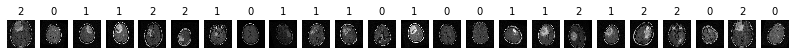

In [8]:
plot_batch(X_train, y_train, argmax=True, as_type=np.uint8)

In [9]:
print(X_train[0].min())
print(X_train[0].max())
X_train.shape

0.0
255.0


(24, 224, 224, 3)

## Build Fine-tuned RESNEXT 50 model

In [10]:
ResNext50, preprocess_input = Classifiers.get('resnext50')

In [11]:
input_shape = X_train[0].shape
input_tensor = Input(shape=input_shape)

clear_session()

resnext_model = ResNext50(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=input_shape,
    classes=1000,
)

# Construct the head of the model that will be placed on top of the the base model.
output = resnext_model.output
output = GlobalAveragePooling2D()(output)

prediction_layer = Dense(
    units=3,
    activation="softmax",
    name="predictions",
)(output)

model = Model(inputs=resnext_model.input, outputs=prediction_layer)

for layer in model.layers[:-6]:
    layer.trainable = False

In [12]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

stage4_unit3_conv3
stage4_unit3_bn3
add_15
stage4_unit3_relu
global_average_pooling2d
predictions


In [13]:
model.summary()
params = count_params(model)
# print(f"Trainable params: {params['trainable_params']:,}")
# print(f"Non-trainable params: {params['non_trainable_params']:,}")
# assert params['trainable_params'] == 6_956_931
# assert params['non_trainable_params'] == 83_648

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']   

## Compile model

In [14]:
model.compile(
    optimizer=Adam(
        learning_rate=0.001,  # (0.001 * np.sqrt(0.1)),
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        amsgrad=False,
        name="Adam",
    ),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Fit model

In [15]:
epochs = 30

set_callbacks = [  # None
    # "lr_schedule",
    "lr_plateau",
    "early_stopping",
    "model_checkpoint",
]

if "lr_schedule" in set_callbacks and "lr_plateau" in set_callbacks:
    set_callbacks.pop(set_callbacks.index("lr_plateau"))
    print("Note: 'LearningRateScheduler' always wins over 'ReduceLROnPlateau'\n")

callbacks = []
callback_names = []

if set_callbacks:
    if "lr_schedule" in set_callbacks:
        learning_rate_schedule = learning_rate_scheduler(
            # epoch_steps=[5, 20],  # None,
            initial_lr=round(float(model.optimizer.learning_rate.numpy()), 8),
            # lr_steps=[0.1, 0.1],  # None,
            # use_factor=True,
            verbose=1
        )
        lr_schedule = LearningRateScheduler(learning_rate_schedule)
        model.optimizer.learning_rate = learning_rate_schedule(0)
        print(
            "[LR SCHEDULE]:\n"
            f"\tEpoch_steps: {getattr(learning_rate_schedule, 'epoch_steps')}\n"
            f"\tInitial_lr: {getattr(learning_rate_schedule, 'initial_lr')}\n"
            f"\tLr_steps: {getattr(learning_rate_schedule, 'lr_steps')}\n"
            f"\tUse_factor: {getattr(learning_rate_schedule, 'use_factor')}\n"
            )
        if getattr(learning_rate_schedule, 'use_factor'):
            epcs = getattr(learning_rate_schedule, 'epoch_steps')
            curr_step = round(float(model.optimizer.learning_rate.numpy()), 8)
            print(str(f"\tEpoch 0: {curr_step:.10f}").rstrip("0"))
            for i, step in enumerate(getattr(learning_rate_schedule, 'lr_steps')):
                curr_step *= step
                print(str(f"\tEpoch {epcs[i]}: {curr_step:.10f}").rstrip("0"))
            print()

        callbacks.append(lr_schedule)
        callback_names.append("lr_schedule")

    if "lr_plateau" in set_callbacks:
        lr_plateau = ReduceLROnPlateau(
            monitor="val_loss",
            factor=np.sqrt(0.1),
            patience=2,
            verbose=1,
            mode="auto",
            # min_delta=0.01,
            cooldown=0,
            min_lr=0.5e-6,
        )
        callbacks.append(lr_plateau)
        callback_names.append("lr_plateau")

    if "early_stopping" in set_callbacks:
        early_stopping = EarlyStopping(
            monitor="val_loss",
            # min_delta=0.01,
            patience=6,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )
        callbacks.append(early_stopping)
        callback_names.append("early_stopping")

    if "model_checkpoint" in set_callbacks:
        model_checkpoint = ModelCheckpoint(
            filepath=p_join(MODELS_PATH, MODEL_NAME + "_" + "checkpoint.hdf5"),
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            options=None,
        )
        callbacks.append(model_checkpoint)
        callback_names.append("model_checkpoint")

print(f"Selected callbacks: {enumerate_oxford(callback_names)}")

Selected callbacks: lr_plateau, early_stopping, and model_checkpoint


In [16]:
TRAIN_STEPS_PER_EPOCH = int(train_gen.n / BATCH_SIZE)
VALID_STEPS_PER_EPOCH = int(valid_gen.n / BATCH_SIZE)
print("Train steps per epoch:", TRAIN_STEPS_PER_EPOCH)
print("Valid steps per epoch:", VALID_STEPS_PER_EPOCH)

Train steps per epoch: 43
Valid steps per epoch: 8


In [17]:
model_operation = "fit"

mkdir_if_not_exists(MODELS_PATH)

clear_session()

if model_operation == "fit":
    history = model.fit(
        x=train_gen,
        epochs=epochs,
        steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
        validation_data=valid_gen,
        validation_steps=VALID_STEPS_PER_EPOCH,
        verbose=2,
        callbacks=callbacks if len(callbacks) > 0 else None,
        # workers=2,
    )

    save_model(model, os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))

    # save model history
    pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"),
        "save",
        history,
    )

elif model_operation == "load":
    model = load_model(os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))
    history = pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"), "load"
    )

elif model_operation == "checkpoint":
    model = load_model(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_checkpoint.hdf5")
    )
    history = None

Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.37048, saving model to /content/drive/MyDrive/tumorclass.info/models/cnn_resnext50_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


43/43 - 37s - loss: 0.6294 - accuracy: 0.7786 - val_loss: 1.3705 - val_accuracy: 0.6406 - lr: 0.0010 - 37s/epoch - 862ms/step
Epoch 2/30

Epoch 00002: val_loss improved from 1.37048 to 0.46393, saving model to /content/drive/MyDrive/tumorclass.info/models/cnn_resnext50_checkpoint.hdf5
43/43 - 10s - loss: 0.2518 - accuracy: 0.9040 - val_loss: 0.4639 - val_accuracy: 0.8438 - lr: 0.0010 - 10s/epoch - 222ms/step
Epoch 3/30

Epoch 00003: val_loss improved from 0.46393 to 0.27494, saving model to /content/drive/MyDrive/tumorclass.info/models/cnn_resnext50_checkpoint.hdf5
43/43 - 10s - loss: 0.1171 - accuracy: 0.9559 - val_loss: 0.2749 - val_accuracy: 0.9010 - lr: 0.0010 - 10s/epoch - 226ms/step
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.27494
43/43 - 6s - loss: 0.0925 - accuracy: 0.9647 - val_loss: 0.5520 - val_accuracy: 0.8229 - lr: 0.0010 - 6s/epoch - 147ms/step
Epoch 5/30

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.

Epoch 00005: val_loss

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Predict

In [18]:
predictions, y_pred, y_true, target_names = predict_gen(model=model, gen=test_gen)

3/3 [==============================] - 7s 213ms/step


In [19]:
predictions[0:5]

array([[9.9603564e-01, 3.9493861e-03, 1.4966036e-05],
       [9.9999535e-01, 4.6342834e-06, 2.3512765e-08],
       [9.9885952e-01, 1.0743426e-03, 6.6089364e-05],
       [9.9821007e-01, 1.6623288e-03, 1.2755131e-04],
       [9.9996436e-01, 3.2668693e-05, 3.0249453e-06]], dtype=float32)

In [20]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2])

In [21]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [22]:
target_names

['normal', 'lgg', 'hgg']

In [23]:
compare_predictions(y_pred, y_true, target_names)

[normal]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  X  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

[lgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 1  1  1  1  1  1  1  1  1  1  1  1  X  1  1  1  1  1  1  1 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

[hgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 2  2  2  2  2  X  2  2  2  2  2  2  2  X  2  2  2  2  2  2 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 



In [24]:
print(f"normal: {TEST_NORMAL_FILES[18]}")
print(f"lgg: {TEST_LGG_FILES[12]}")
print(f"hgg: {TEST_HGG_FILES[12]}")

normal: 8.jpg
lgg: 33.jpg
hgg: 53.jpg


In [25]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "normal", "8.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: LGG with 66.58% confidence.

Ratio
Normal: 33.40%
LGG: 66.58%
HGG: 0.02%


In [26]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "lgg", "33.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: NORMAL with 94.30% confidence.

Ratio
Normal: 94.30%
LGG: 5.65%
HGG: 0.05%


In [27]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "hgg", "53.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: HGG with 99.11% confidence.

Ratio
Normal: 0.00%
LGG: 0.89%
HGG: 99.11%


## Evaluate

In [28]:
eval_loss, eval_accuracy = model.evaluate(
    x=test_gen,
    batch_size=BATCH_SIZE,
    verbose=1
)

print(f"Evaluation loss: {eval_loss:.2f}")
print(f"Evaluation accuracy: {eval_accuracy*100:.2f}%")

3/3 [==============================] - 0s 114ms/step - loss: 0.1244 - accuracy: 0.9333
Evaluation loss: 0.12
Evaluation accuracy: 93.33%


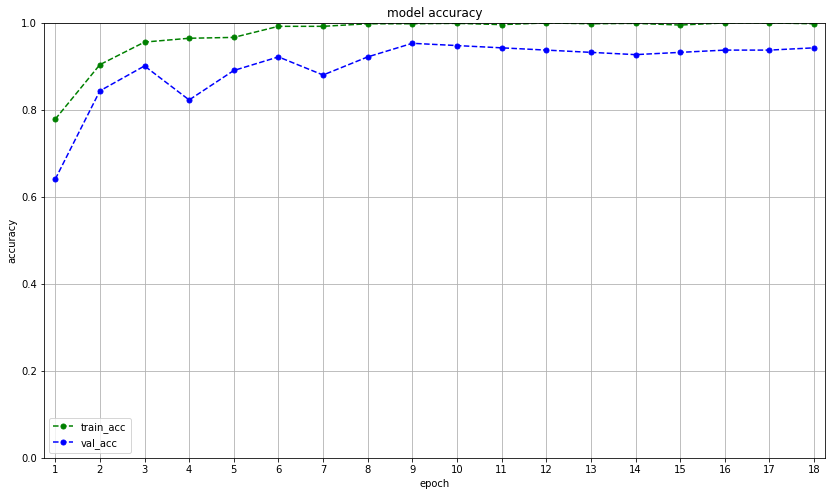

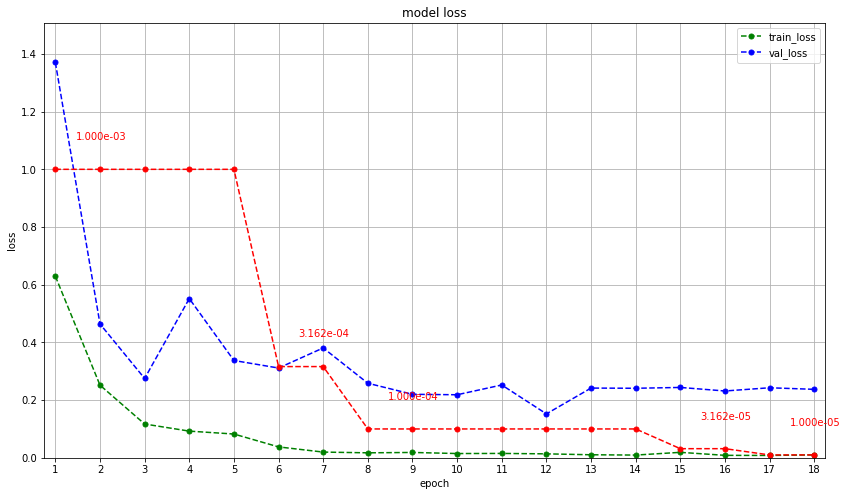

In [29]:
if history is not None:
    plot_epochs(
        history=history,
        filepath=f"{MODELS_PATH}{MODEL_NAME}",
        plot_lr=2,
        lr_x_offset=0.45,
        lr_y_offset=0.095,
        scale=1000,
    )

In [30]:
cm = confusion_matrix(
    y_pred=y_pred,
    y_true=y_true,
    labels=CLASSES,
    save=True,
    path=MODELS_PATH,
    file_name=MODEL_NAME,
)

In [31]:
cm.imbalance

False

In [32]:
# print four lines. Justify text after colon
print(
    f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}\n"
    f"{cm.Overall_ACC*100:<10.2f} {cm.PPV_Macro:<10.2f}"
    f"{cm.TPR_Macro:<10.2f} {cm.F1_Macro:<10.2f}"
)

Accuracy   Precision  Recall     F1 Score  
93.33      0.94      0.93       0.93      


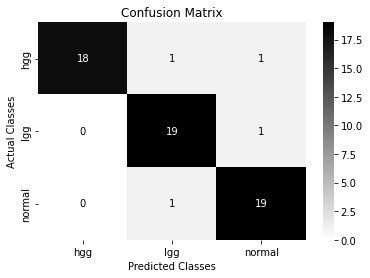

In [33]:
cm.plot(plot_lib = "seaborn", number_label=True)

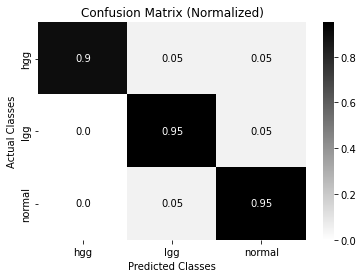

In [34]:
cm.plot(plot_lib = "seaborn", number_label=True, normalized=True)

In [35]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=target_names))


Accuracy: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.94
Macro Recall: 0.93
Macro F1-score: 0.93

Weighted Precision: 0.94
Weighted Recall: 0.93
Weighted F1-score: 0.93

Classification Report

              precision    recall  f1-score   support

      normal       0.90      0.95      0.93        20
         lgg       0.90      0.95      0.93        20
         hgg       1.00      0.90      0.95        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

